In [1]:
import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from flow_matching.supervised.odes_sdes import CFGVectorFieldODE
from flow_matching.supervised.simulators import EulerSimulator
from flow_matching.supervised.alphas_betas import LinearAlpha, LinearBeta
from flow_matching.supervised.prob_paths import GaussianConditionalProbabilityPath
from flow_matching.whar.sampler import WHARSampler
from flow_matching.whar.ae_cond import CondSpectrogramAE
from flow_matching.whar.latent_transformer import FlowTransformerBackbone
from flow_matching.latent.training_flow import LatentFlowTrainer

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

print(device)

mps


In [3]:
sampler = WHARSampler()

Creating config hash...
Checking download...
Download exists.
Checking sessions...
Sessions exist.
Validating common format...
[########################################] | 100% Completed | 648.00 ms
Common format validated.
Checking windowing...
Loading config hash...
Windowing exists.
subject_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
activity_ids: [0 1 2 3 4 5]
Postprocessing...


Loading windows: 100%|██████████| 9499/9499 [00:07<00:00, 1284.98it/s]


Getting normalization parameters...
Loading config hash...
Creating normalization parameters hash...
Loading normalization parameters hash...


Loading samples: 100%|██████████| 9499/9499 [00:02<00:00, 4145.14it/s]


In [4]:
shape = sampler.get_shape()
num_channels = shape[1]
print(shape)

num_classes = len(sampler.sampler.get_class_weights(sampler.train_indices).keys())
print(num_classes)

[18, 32, 32]
6


In [5]:
ae = CondSpectrogramAE(latent_channels=20).to(device)
ae.load_state_dict(torch.load("cond_ae_small.pt"))

path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=[20, 4, 4],
    alpha=LinearAlpha(),
    beta=LinearBeta(),
).to(device)

vf = FlowTransformerBackbone(num_classes=num_classes).to(device)

trainer = LatentFlowTrainer(path=path, model=vf, ae=ae, eta=0.1, null_class=num_classes)

In [6]:
trainer.train(num_epochs=2000, device=device, lr=1e-3, batch_size=64)

Training model with size: 1.076 MiB


Epoch 1999, loss: 0.072: 100%|██████████| 2000/2000 [02:30<00:00, 13.30it/s]


In [21]:
torch.save(vf.state_dict(), "latent_transformer.pt")

In [7]:
vf.load_state_dict(torch.load("latent_vf.pt"))

<All keys matched successfully>

100%|██████████| 99/99 [00:00<00:00, 108.05it/s]


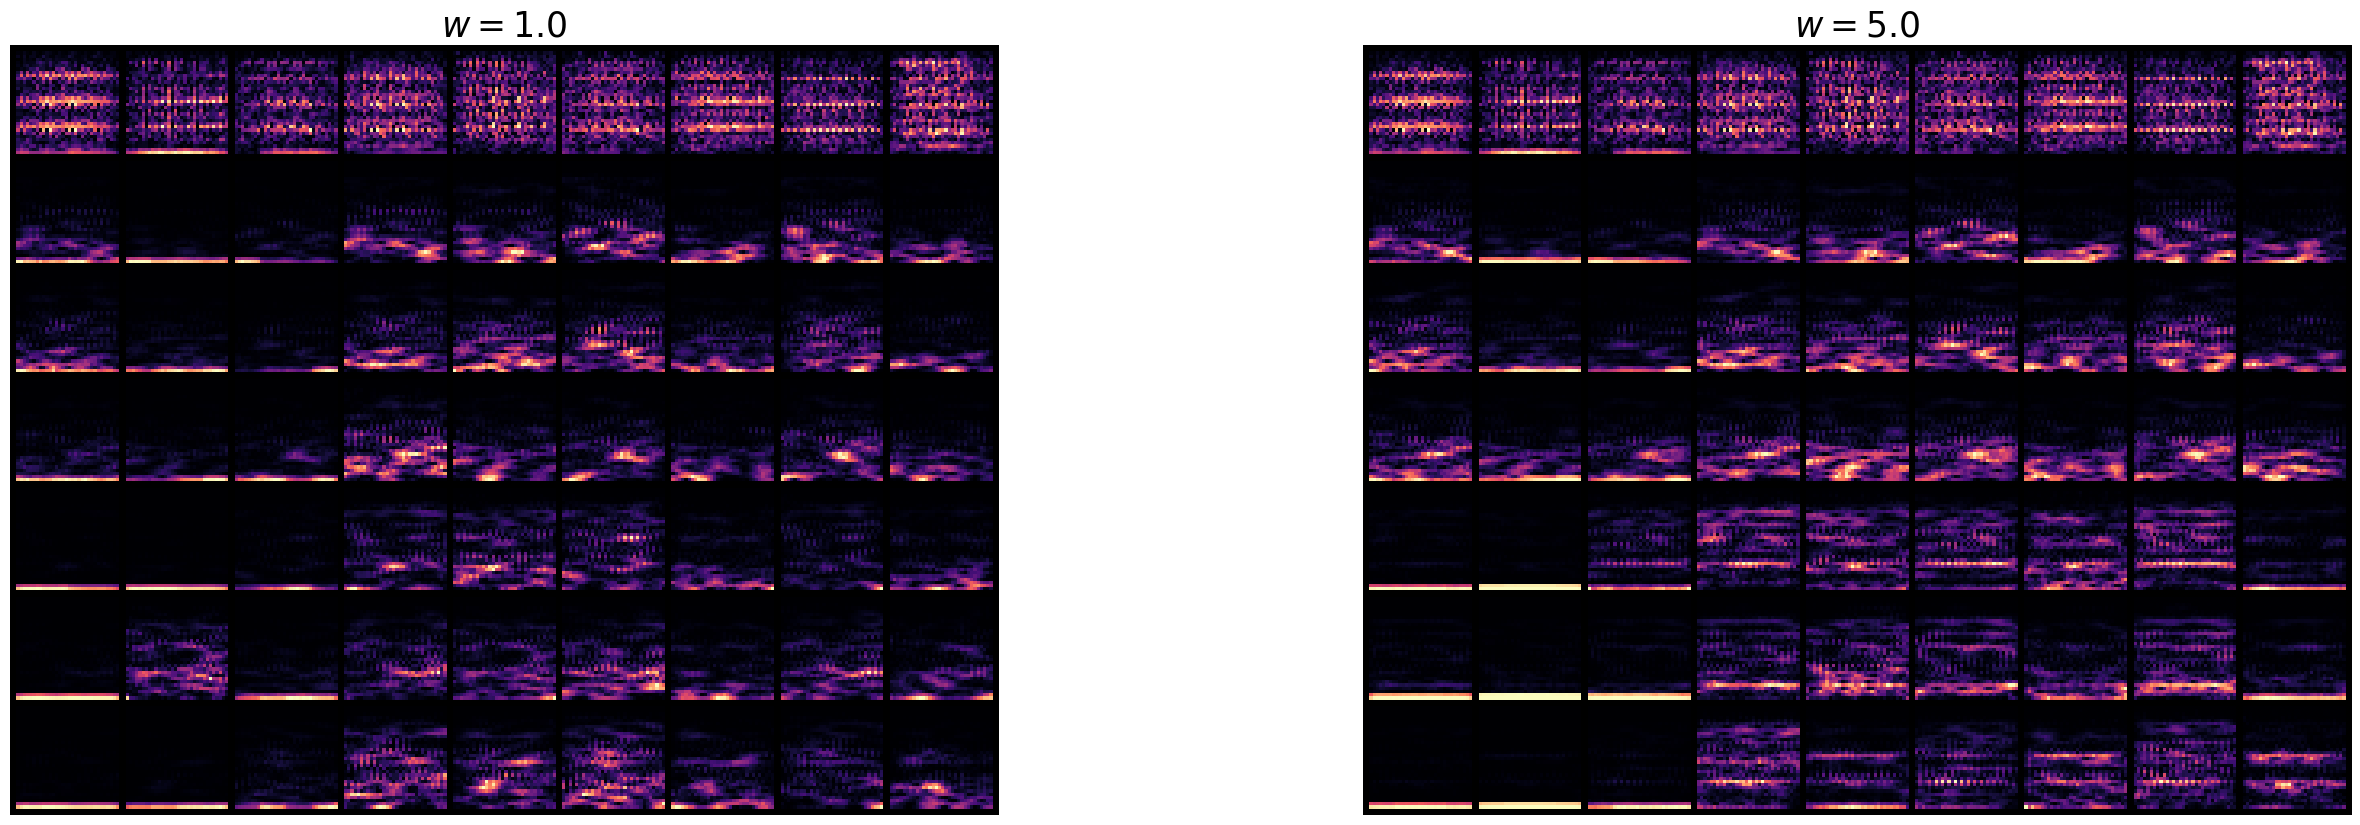

In [7]:
import numpy as np
from torch import vmap

from flow_matching.whar.stft import decompress_stft


num_timesteps = 100
guidance_scales = [1.0, 5.0]

fig, axes = plt.subplots(
    1, len(guidance_scales), figsize=(num_channels // 2 * len(guidance_scales), 10)
)

# Sample initial conditions (+1 for null class)
y = torch.arange(num_classes + 1).to(device)

num_samples = y.shape[0]
x0, _ = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)
x0 = x0.to(device)

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(vf, guidance_scale=w, null_class=num_classes)
    simulator = EulerSimulator(ode)

    # Simulate
    ts = (
        torch.linspace(0, 1, num_timesteps)
        .view(1, -1, 1, 1, 1)
        .expand(num_samples, -1, 1, 1, 1)
        .to(device)
    )

    x1 = simulator.simulate(x0, ts, y=y)

    x1 = ae.decode(x1, y)

    x1 = x1.detach().cpu()

    B, C, H, W = x1.shape
    x1 = x1.view(B, C // 2, 2, H, W)

    x1 = vmap(decompress_stft)(x1)

    x1_mag = torch.sqrt(
        x1[:, :, 0] ** 2 + x1[:, :, 1] ** 2 + 1e-8
    )  # shape: (B, C//2, H, W)

    # Flatten batch and channel dims to (B * (C//2), H, W)
    x1_mag_flat = x1_mag.view(-1, H, W).cpu().numpy()

    # Normalize each image to [0,1] for colormap
    x1_min = x1_mag_flat.min(axis=(1, 2), keepdims=True)
    x1_max = x1_mag_flat.max(axis=(1, 2), keepdims=True)
    x1_norm = (x1_mag_flat - x1_min) / (x1_max - x1_min + 1e-8)

    cmap = plt.get_cmap("magma")
    heatmaps = [
        cmap(img)[:, :, :3] for img in x1_norm
    ]  # apply colormap and drop alpha channel
    heatmaps = np.stack(heatmaps, axis=0)

    # Convert to tensor and rearrange to (batch, channels, height, width)
    heatmaps_t = torch.tensor(heatmaps).permute(0, 3, 1, 2)

    # Create grid: nrow = C//2 (number of channels per sample)
    grid = make_grid(heatmaps_t, nrow=(C // 2), padding=2)

    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), origin="lower")
    axes[idx].axis("off")
    axes[idx].set_title(f"$w={w:.1f}$", fontsize=25)
plt.show()

activity_id
0    28
Name: count, dtype: int64
activity_id
1    22
Name: count, dtype: int64
activity_id
2    27
Name: count, dtype: int64
activity_id
3    32
Name: count, dtype: int64
activity_id
4    18
Name: count, dtype: int64
activity_id
5    24
Name: count, dtype: int64


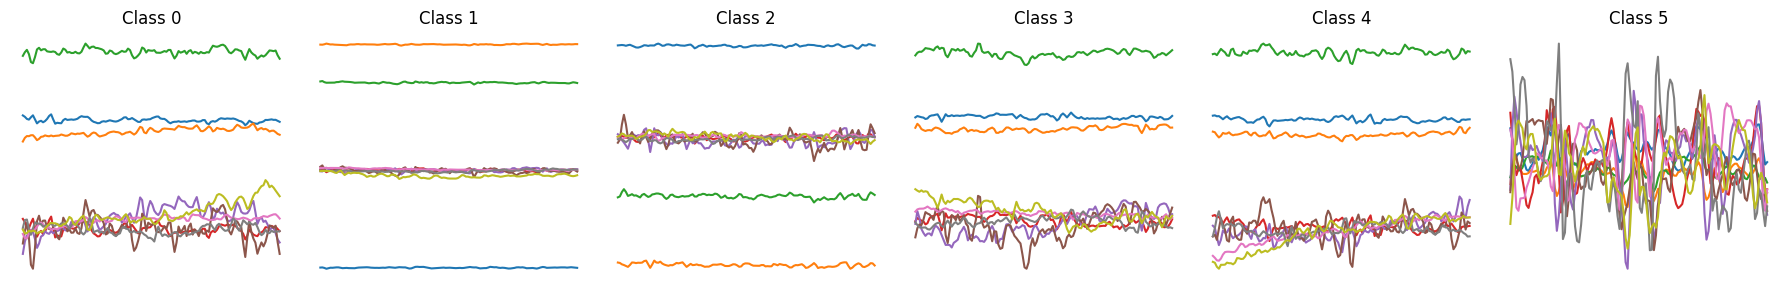

In [45]:
import random
from flow_matching.whar.stft import istft_transform

num_samples = 6

fig, axes = plt.subplots(
    nrows=1,
    ncols=num_samples,
    figsize=(3 * num_samples, 3 * len(guidance_scales)),
)

# random int
seed = random.randint(0, 1000)

samples = []

for i in range(0, num_samples):
    x1, _ = sampler.sample_test(1, class_label=i, seed=seed)
    samples.append(x1)

x1 = torch.cat(samples, dim=0)

B, C, H, W = x1.shape
x1 = x1.view(B, C // 2, 2, H, W)

x1 = x1.cpu()
x1 = vmap(decompress_stft)(x1)
x1 = [istft_transform(x) for x in x1]

for col_idx in range(num_samples):
    ax = axes[col_idx]
    ax.plot(x1[col_idx])
    ax.set_title(f"Class {col_idx}")
    ax.axis("off")

plt.tight_layout()
plt.show()

100%|██████████| 99/99 [00:00<00:00, 111.80it/s]


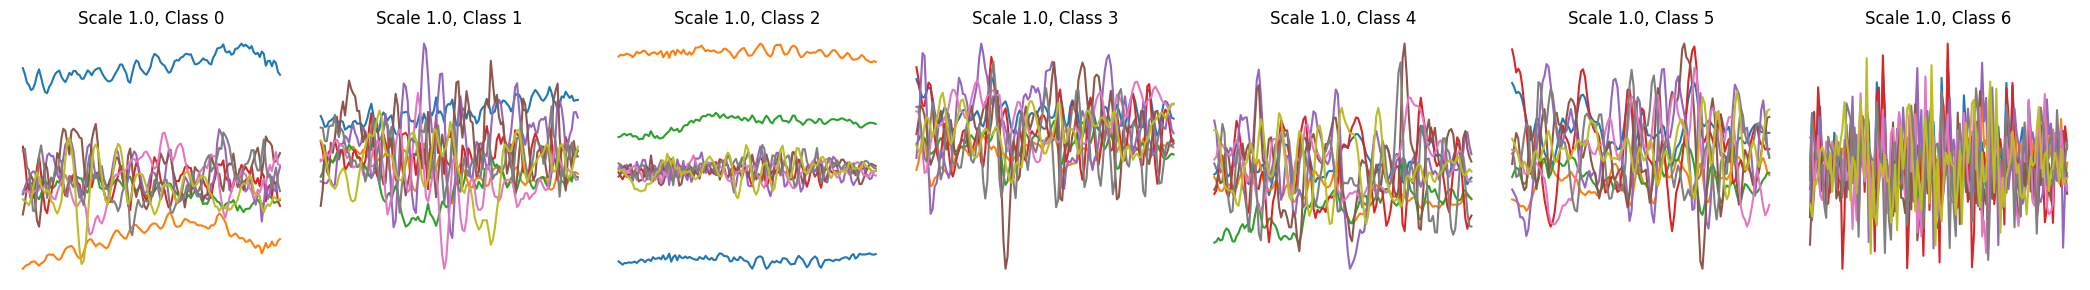

In [53]:
import matplotlib.pyplot as plt

from flow_matching.whar.stft import istft_transform

num_samples = 7
num_timesteps = 100
guidance_scales = [1.0]

# Sample initial conditions (+1 for null class)
y = torch.arange(num_classes + 1).to(device)

num_samples = y.shape[0]
x0, _ = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)
x0 = x0.to(device)

fig, axes = plt.subplots(
    nrows=len(guidance_scales),
    ncols=num_samples,
    figsize=(3 * num_samples, 3 * len(guidance_scales)),
)

if len(guidance_scales) == 1:
    axes = [axes]  # make it always 2D indexable

for row_idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(vf, guidance_scale=w, null_class=num_classes)
    simulator = EulerSimulator(ode)

    # Simulate
    ts = (
        torch.linspace(0, 1, num_timesteps)
        .view(1, -1, 1, 1, 1)
        .expand(num_samples, -1, 1, 1, 1)
        .to(device)
    )

    x1 = simulator.simulate(x0, ts, y=y)
    x1 = ae.decode(x1, y)

    B, C, H, W = x1.shape
    x1 = x1.view(B, C // 2, 2, H, W)
    x1 = x1.detach().cpu()
    x1 = vmap(decompress_stft)(x1)
    x1 = [istft_transform(x) for x in x1]

    for col_idx in range(num_samples):
        ax = axes[row_idx][col_idx]
        ax.plot(x1[col_idx])
        ax.set_title(f"Scale {w}, Class {col_idx}")
        ax.axis("off")

plt.tight_layout()
plt.show()